Лабораторная работа №3 по курсу "Методы машинного обучения"

Карягин А.Д. группа ИУ5-22М

Задание

Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:

1. масштабирование признаков (не менее чем тремя способами);
2. обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);
3. обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);
4. отбор признаков:

один метод из группы методов фильтрации (filter methods);

один метод из группы методов обертывания (wrapper methods);

один метод из группы методов вложений (embedded methods).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import scipy.stats as stats
import six
import sys
from sklearn.impute import SimpleImputer
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')




In [2]:
!wget  https://raw.githubusercontent.com/azar-s91/dataset/master/BankChurners.csv
data = pd.read_csv('BankChurners.csv', sep=",")
data.head()


--2022-06-08 11:17:04--  https://raw.githubusercontent.com/azar-s91/dataset/master/BankChurners.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1210878 (1.2M) [text/plain]
Saving to: ‘BankChurners.csv’

BankChurners.csv    100%[===================>]   1.15M  --.-KB/s    in 0.04s   

2022-06-08 11:17:05 (26.9 MB/s) - ‘BankChurners.csv’ saved [1210878/1210878]



,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Масштабирование признаков


In [3]:
data['Total_Trans_Ct'].describe()

count    10127.000000
mean        64.858695
std         23.472570
min         10.000000
25%         45.000000
50%         67.000000
75%         81.000000
max        139.000000
Name: Total_Trans_Ct, dtype: float64

In [4]:
minMaxScaler = MinMaxScaler()
data['Total_Trans_Ct_minmax'] = minMaxScaler.fit_transform(data[['Total_Trans_Ct']])
data['Total_Trans_Ct_minmax'].describe()

count    10127.000000
mean         0.425261
std          0.181958
min          0.000000
25%          0.271318
50%          0.441860
75%          0.550388
max          1.000000
Name: Total_Trans_Ct_minmax, dtype: float64

In [5]:
standardScaler = StandardScaler()
data['Total_Trans_Ct_standard'] = standardScaler.fit_transform(data[['Total_Trans_Ct']])
data['Total_Trans_Ct_standard'].describe()


count    1.012700e+04
mean     1.194179e-14
std      1.000049e+00
min     -2.337256e+00
25%     -8.460801e-01
50%      9.123036e-02
75%      6.877007e-01
max      3.158792e+00
Name: Total_Trans_Ct_standard, dtype: float64

In [6]:
robustScaler = RobustScaler()
data['Total_Trans_Ct_robust'] = robustScaler.fit_transform(data[['Total_Trans_Ct']])
data['Total_Trans_Ct_robust'].describe()

count    10127.000000
mean        -0.059481
std          0.652016
min         -1.583333
25%         -0.611111
50%          0.000000
75%          0.388889
max          2.000000
Name: Total_Trans_Ct_robust, dtype: float64

Обработка выбросов

In [7]:
def diagnostic_plots(df, variable):
 fig, ax = plt.subplots(figsize=(20,10))
 plt.subplot(2, 2, 1)
 sns.kdeplot(data=data, x=variable)
 ## Q-Q plot
 plt.subplot(2, 2, 2)
 stats.probplot(df[variable], dist="norm", plot=plt)
 # ящик с усами
 plt.subplot(2, 2, 3)
 sns.boxplot(x=df[variable])
 # ящик с усами
 plt.subplot(2, 2, 4)
 df[variable].hist(bins=30)
 plt.show()


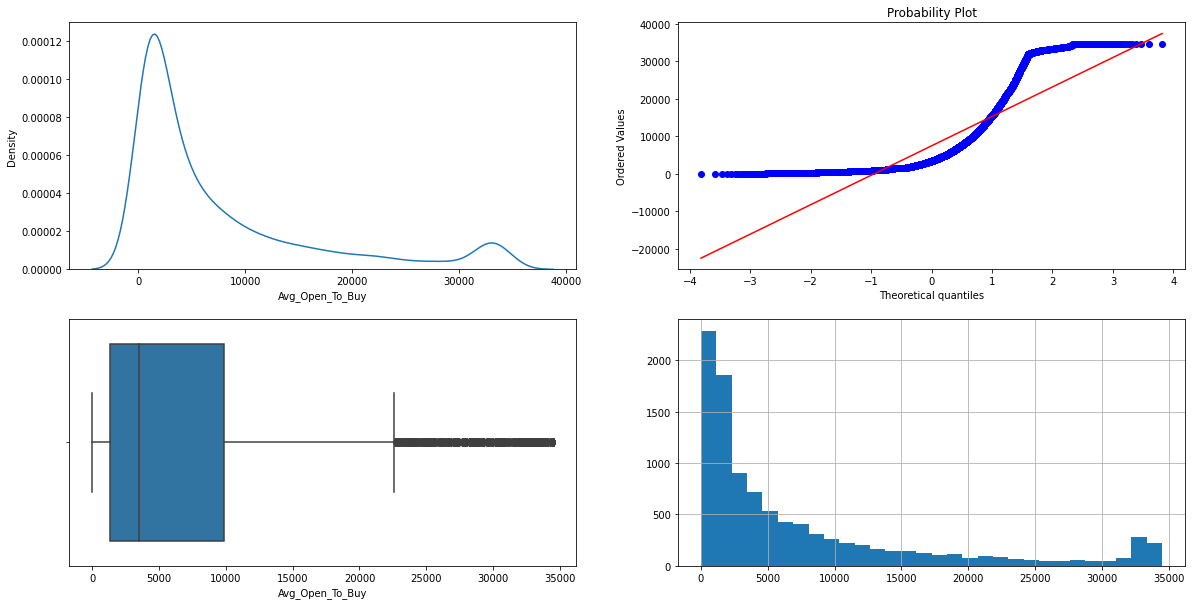

In [8]:
diagnostic_plots(data, 'Avg_Open_To_Buy')


In [9]:
outlierBoundaryType = {
 'SIGMA': 1,
 'QUANTILE': 2,
 'IRQ': 3
}


In [10]:
def get_outlier_boundaries(df, col, outlier_boundary_type):
 if outlier_boundary_type == outlierBoundaryType['SIGMA']:
  K1 = 3
  lower_boundary = df[col].mean() - (K1 * df[col].std())
  upper_boundary = df[col].mean() + (K1 * df[col].std())
 elif outlier_boundary_type == outlierBoundaryType['QUANTILE']:
  lower_boundary = df[col].quantile(0.05)
  upper_boundary = df[col].quantile(0.95)
 elif outlier_boundary_type == outlierBoundaryType['IRQ']:
  K2 = 1.5
  IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
  lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
  upper_boundary = df[col].quantile(0.75) + (K2 * IQR)
 else:
  return 0, 0
 return lower_boundary, upper_boundary

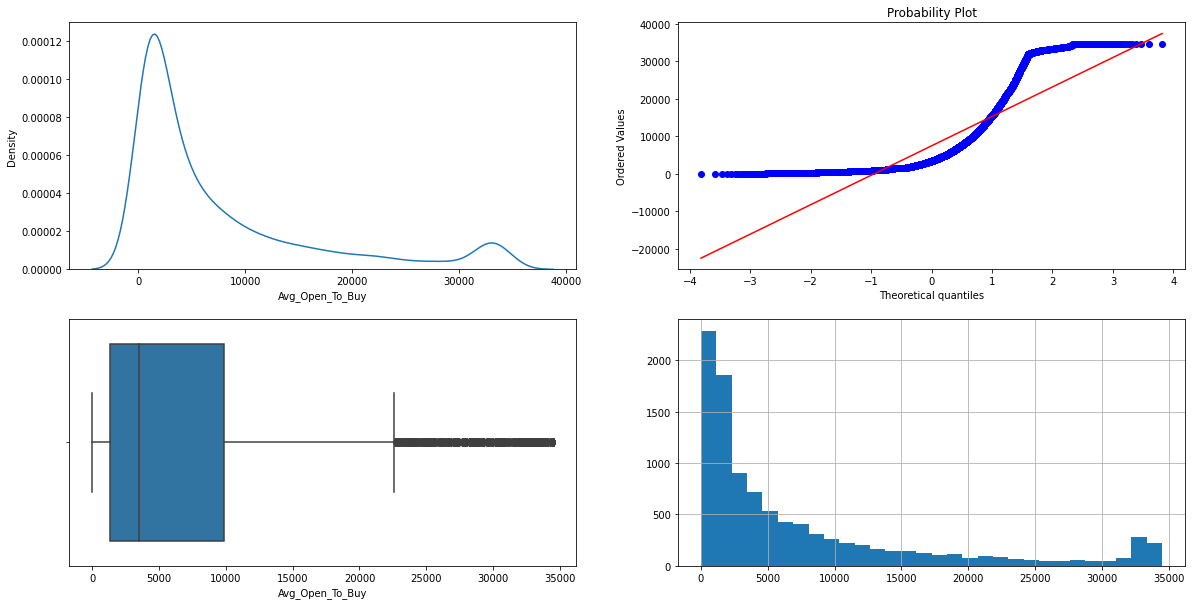

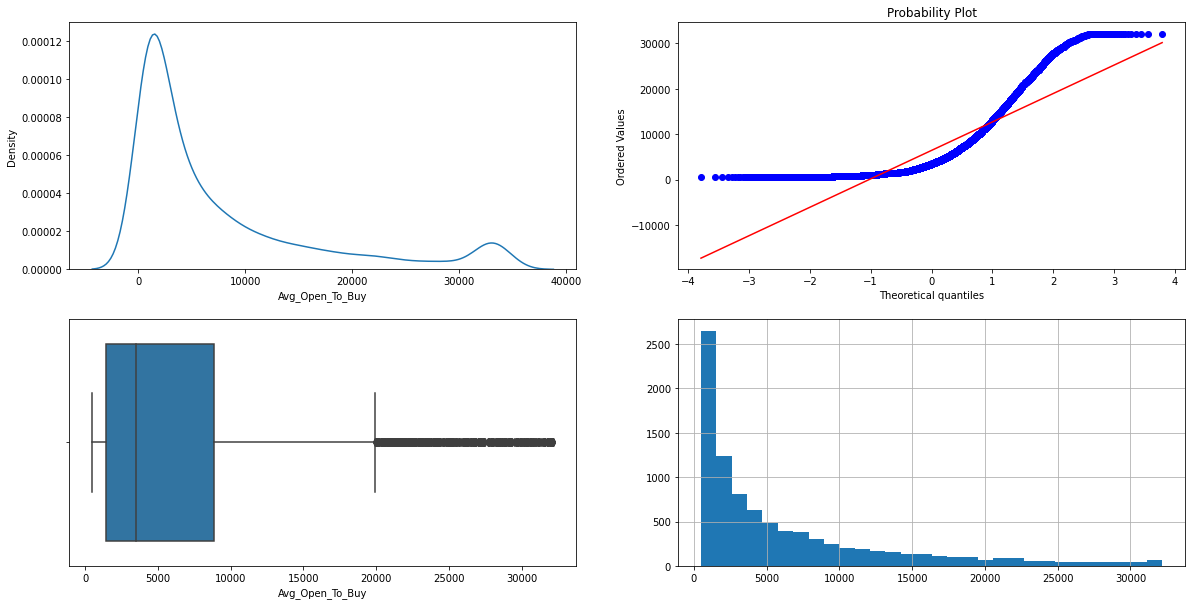

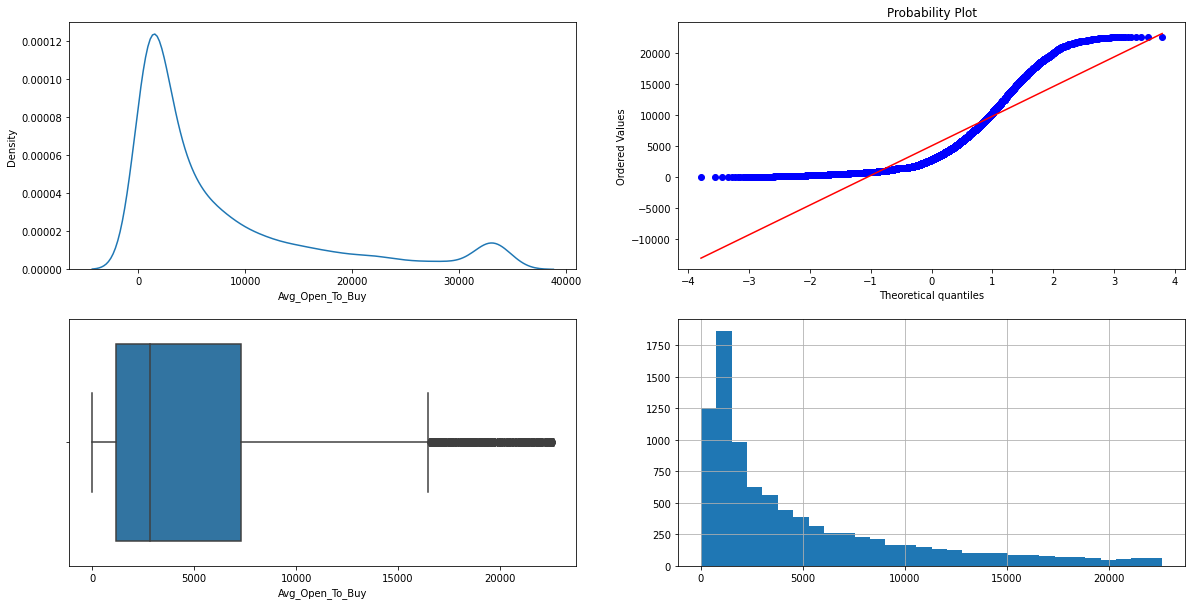

In [11]:
for key, value in outlierBoundaryType.items():
 col = 'Avg_Open_To_Buy'
 lower_boundary, upper_boundary = get_outlier_boundaries(data, col, value)
 outliers_temp = np.where(data[col] > upper_boundary, True, np.where(data[col] < lower_boundary, True, False))
 data_trimmed = data.loc[~(outliers_temp), ]
 diagnostic_plots(data_trimmed, col)

Обработка нестандартного признака

In [12]:
!wget https://raw.githubusercontent.com/GAMES-UChile/mogptk/master/examples/data/AirQualityUCI.csv
data2 = pd.read_csv('AirQualityUCI.csv', sep = ";")
data2 = data2.dropna(subset=['T'])
data2.head()

--2022-06-08 11:17:10--  https://raw.githubusercontent.com/GAMES-UChile/mogptk/master/examples/data/AirQualityUCI.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 785065 (767K) [text/plain]
Saving to: ‘AirQualityUCI.csv’

AirQualityUCI.csv   100%[===================>] 766.67K  --.-KB/s    in 0.03s   

2022-06-08 11:17:11 (25.6 MB/s) - ‘AirQualityUCI.csv’ saved [785065/785065]



,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [13]:
imputer = SimpleImputer(strategy="mean")
data2[['CO']] = imputer.fit_transform(data2[['CO(GT)']])
data2[['NOx']] = imputer.fit_transform(data2[['PT08.S3(NOx)']])
data2[['NO2']] = imputer.fit_transform(data2[['NO2(GT)']])
data2 = data2.drop(columns=['NMHC(GT)'])
data2.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,CO,NOx,NO2
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2.6,1056.0,113.0
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2.0,1174.0,92.0
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2.2,1140.0,114.0
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2.2,1092.0,122.0
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,1.6,1205.0,116.0


In [14]:
time_hour = []
for item in data2['Time']:
 time_hour.append(int(item.split('.')[0]))
day = []
month = []
year = []
for item in data2['Date']:
 day.append(int(item.split('/')[0]))
 month.append(int(item.split('/')[1]))
 year.append(int(item.split('/')[2]))
data2.insert(1, 'Day', day, allow_duplicates=False)
data2.insert(2, 'Month', month, allow_duplicates=False)
data2.insert(3, 'Year', year, allow_duplicates=False)

data2.insert(5, 'Time(Hours)', time_hour, allow_duplicates=False)
data2 = data2.drop(columns='Date')
data2 = data2.drop(columns='Time')
data2.head()


,Day,Month,Year,Time(Hours),CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),...,PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,CO,NOx,NO2
0,10,3,2004,18,2.6,1360.0,11.9,1046.0,166.0,1056.0,...,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2.6,1056.0,113.0
1,10,3,2004,19,2.0,1292.0,9.4,955.0,103.0,1174.0,...,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2.0,1174.0,92.0
2,10,3,2004,20,2.2,1402.0,9.0,939.0,131.0,1140.0,...,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2.2,1140.0,114.0
3,10,3,2004,21,2.2,1376.0,9.2,948.0,172.0,1092.0,...,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2.2,1092.0,122.0
4,10,3,2004,22,1.6,1272.0,6.5,836.0,131.0,1205.0,...,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,1.6,1205.0,116.0


Отбор признаков по корреляции


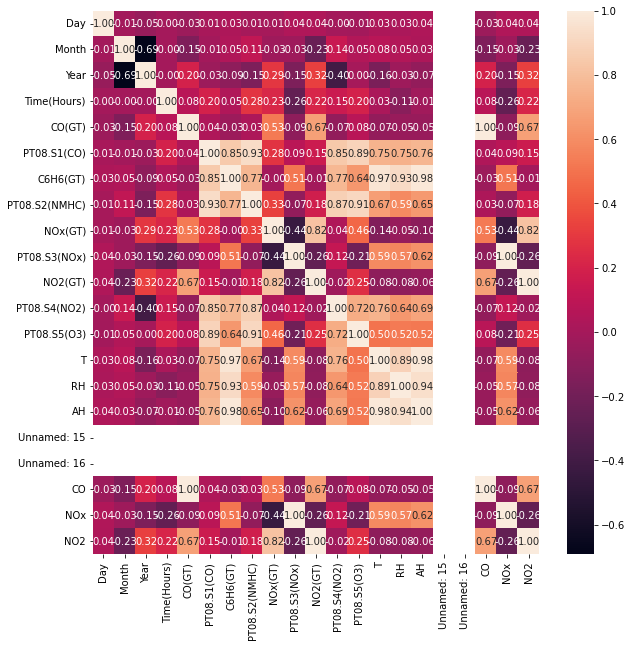

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data2.corr(method='pearson'), annot=True, fmt='.2f')


In [16]:
for row in data2.corr():
 if data2.corr()[row]['AH'] >= 0.8:
  print(row, data2.corr()[row]['AH'])

C6H6(GT) 0.984555069291292
T 0.9810012182689022
RH 0.9439949303397153
AH 1.0


Отбор признаков методом обёртывания


In [17]:
knn = KNeighborsRegressor()
efs1 = EFS(knn,
 min_features=2,
 max_features=4,
 scoring='r2',
 print_progress=True,
 cv=5)
efs1 = efs1.fit(data2.drop(columns=['AH']), data2['AH'])
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 6175/6175

Best accuracy score: 1.00
Best subset (indices): (13, 14)
Best subset (corresponding names): ('T', 'RH')


Отбор признаков методом вложений


In [18]:
data2.head()

,Day,Month,Year,Time(Hours),CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),...,PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,CO,NOx,NO2
0,10,3,2004,18,2.6,1360.0,11.9,1046.0,166.0,1056.0,...,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2.6,1056.0,113.0
1,10,3,2004,19,2.0,1292.0,9.4,955.0,103.0,1174.0,...,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2.0,1174.0,92.0
2,10,3,2004,20,2.2,1402.0,9.0,939.0,131.0,1140.0,...,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2.2,1140.0,114.0
3,10,3,2004,21,2.2,1376.0,9.2,948.0,172.0,1092.0,...,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2.2,1092.0,122.0
4,10,3,2004,22,1.6,1272.0,6.5,836.0,131.0,1205.0,...,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,1.6,1205.0,116.0
